<a href="https://colab.research.google.com/github/hevertonvalerio/Challenge/blob/main/challenge_modelo_2_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artigo Arima e Fourier


In [13]:
!pip install pmdarima


In [14]:
import yfinance as yf

# Download data
gs = yf.download("GS", start="2011-01-01", end="2023-03-01")

[*********************100%***********************]  1 of 1 completed


In [15]:
import pandas as pd

# Preprocess data
dataset_ex_df = gs.copy()
dataset_ex_df = dataset_ex_df.reset_index()
dataset_ex_df['Date'] = pd.to_datetime(dataset_ex_df['Date'])
dataset_ex_df.set_index('Date', inplace=True)
dataset_ex_df = dataset_ex_df['Close'].to_frame()

In [16]:
from pmdarima.arima import auto_arima

# Auto ARIMA to select optimal ARIMA parameters
model = auto_arima(dataset_ex_df['Close'], seasonal=False, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=16.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16866.845, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16868.835, Time=0.41 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16868.835, Time=1.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16865.562, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16870.383, Time=5.96 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 24.555 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3059
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -8431.781
Date:                Mon, 14 Oct 2024   AIC                          16865.562
Time:                        22:10:06   BIC                          16871.588
Sample:                             0   HQIC                         16867.728
        

In [17]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Define the ARIMA model
def arima_forecast(history):
    # Fit the model
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit()

    # Make the prediction
    output = model_fit.forecast()
    yhat = output[0]
    return yhat

# Split data into train and test sets
X = dataset_ex_df.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

# Walk-forward validation
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    # Generate a prediction
    yhat = arima_forecast(history)
    predictions.append(yhat)
    # Add the predicted value to the training set
    obs = test[t]
    history.append(obs)

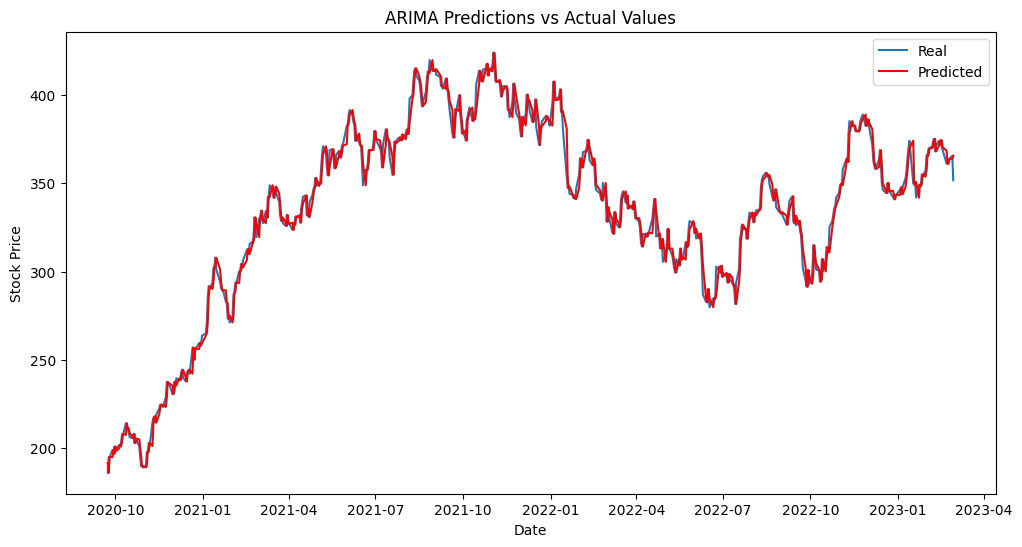

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(dataset_ex_df.iloc[size:,:].index, test, label='Real')
plt.plot(dataset_ex_df.iloc[size:,:].index, predictions, color='red', label='Predicted')
plt.title('ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


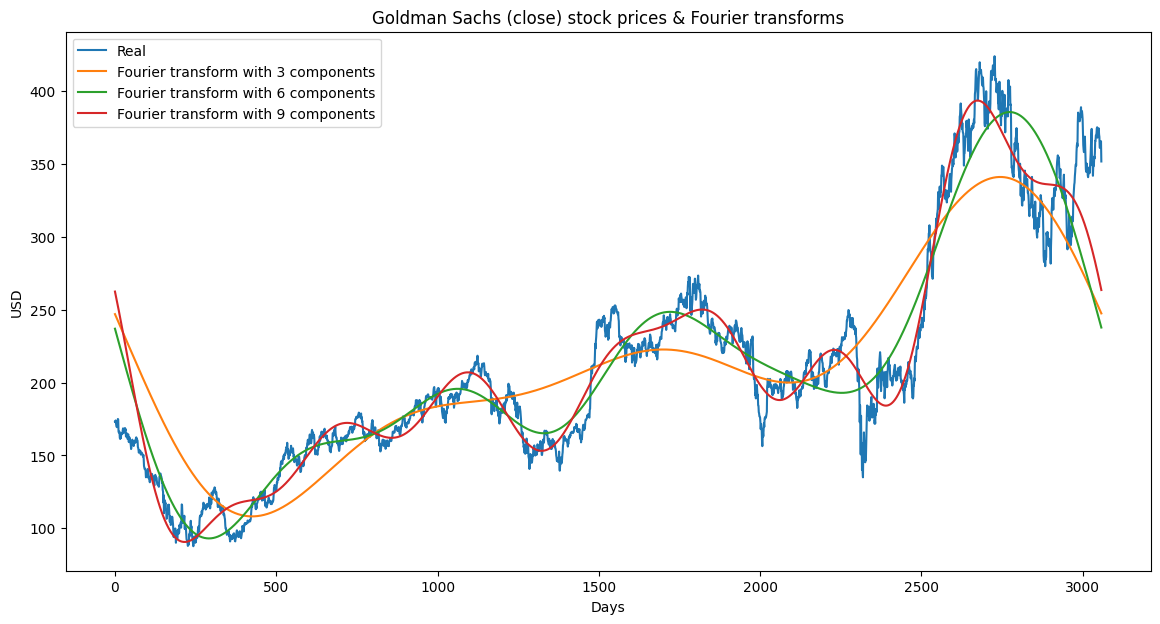

In [19]:
# Calculate the Fourier Transform
data_FT = dataset_ex_df[['Close']]
close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

# Plot the Fourier Transforms
plt.figure(figsize=(14, 7), dpi=100)
plt.plot(np.asarray(data_FT['Close'].tolist()),  label='Real')
for num_ in [3, 6, 9]:
    fft_list_m10= np.copy(close_fft); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

In [20]:
# Calculate EMA
def ema(close, period=20):
    return close.ewm(span=period, adjust=False).mean()

# Calculate RSI
def rsi(close, period=14):
    delta = close.diff()
    gain, loss = delta.copy(), delta.copy()
    gain[gain < 0] = 0
    loss[loss > 0] = 0
    avg_gain = gain.rolling(period).mean()
    avg_loss = abs(loss.rolling(period).mean())
    rs = avg_gain / avg_loss
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

# Calculate MACD
def macd(close, fast_period=12, slow_period=26, signal_period=9):
    fast_ema = close.ewm(span=fast_period, adjust=False).mean()
    slow_ema = close.ewm(span=slow_period, adjust=False).mean()
    macd_line = fast_ema - slow_ema
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    histogram = macd_line - signal_line
    return macd_line

# Calculate OBV
def obv(close, volume):
    obv = np.where(close > close.shift(), volume, np.where(close < close.shift(), -volume, 0)).cumsum()
    return obv

In [21]:
# Add technical indicators to dataset DF
dataset_ex_df['ema_20'] = ema(gs["Close"], 20)
dataset_ex_df['ema_50'] = ema(gs["Close"], 50)
dataset_ex_df['ema_100'] = ema(gs["Close"], 100)

dataset_ex_df['rsi'] = rsi(gs["Close"])
dataset_ex_df['macd'] = macd(gs["Close"])
dataset_ex_df['obv'] = obv(gs["Close"], gs["Volume"])

# Create arima DF using predictions
arima_df = pd.DataFrame(history, index=dataset_ex_df.index, columns=['ARIMA'])

# Set Fourier Transforms DF
fft_df.reset_index(inplace=True)
fft_df['index'] = pd.to_datetime(dataset_ex_df.index)
fft_df.set_index('index', inplace=True)
fft_df_real = pd.DataFrame(np.real(fft_df['fft']), index=fft_df.index, columns=['Fourier_real'])
fft_df_imag = pd.DataFrame(np.imag(fft_df['fft']), index=fft_df.index, columns=['Fourier_imag'])

# Technical Indicators DF
technical_indicators_df = dataset_ex_df[['ema_20', 'ema_50', 'ema_100', 'rsi', 'macd', 'obv', 'Close']]

# Merge DF
merged_df = pd.concat([arima_df, fft_df_real, fft_df_imag, technical_indicators_df], axis=1)
merged_df = merged_df.dropna()
merged_df

,ARIMA,Fourier_real,Fourier_imag,ema_20,ema_50,ema_100,rsi,macd,obv,Close
2011-01-24,166.300003,87.137150,5343.029528,170.488136,171.808550,172.382968,34.192019,-1.460390,-19511600,166.300003
2011-01-25,161.979996,-7813.278601,8773.122791,169.677837,171.423117,172.176968,28.354109,-1.950223,-30771400,161.979996
2011-01-26,161.309998,766.185261,6616.367848,168.880900,171.026524,171.961781,25.009826,-2.365217,-37509400,161.309998
2011-01-27,164.029999,-4929.224001,4955.021202,168.418909,170.752150,171.804716,34.460467,-2.446421,-31473400,164.029999
2011-01-28,161.770004,580.960458,2680.538654,167.785680,170.399909,171.606009,33.518101,-2.662448,-36043400,161.770004
...,...,...,...,...,...,...,...,...,...,...
2023-02-22,360.890015,-3663.367143,-16638.750495,365.581345,360.615446,353.455957,44.090269,2.571489,28193100,360.890015
2023-02-23,363.540009,-15720.095564,-15667.902776,365.386932,360.730135,353.655641,42.525844,2.106664,30124500,363.540009
2023-02-24,363.850006,-833.983943,-84642.020461,365.240558,360.852483,353.857510,42.278467,1.743207,32553100,363.850006
2023-02-27,365.529999,29944.600549,-77890.567881,365.268124,361.035915,354.088648,43.466414,1.572598,35395500,365.529999


In [22]:
# Separate in Train and Test Dfs
train_size = int(len(merged_df) * 0.8)
train_df, test_df = merged_df.iloc[:train_size], merged_df.iloc[train_size:]

In [23]:
from sklearn.preprocessing import MinMaxScaler

# Scale the features
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df.drop('Close', axis=1))
test_scaled = scaler.transform(test_df.drop('Close', axis=1))

# Convert the scaled data back to a DataFrame
train_scaled_df = pd.DataFrame(train_scaled, columns=train_df.columns[:-1], index=train_df.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=test_df.columns[:-1], index=test_df.index)

# Merge the scaled features with the target variable
train_scaled_df['Close'] = train_df['Close']
test_scaled_df['Close'] = test_df['Close']

# Split the scaled data into Features and Label
X_train = train_scaled_df.iloc[:, :-1].values
y_train = train_scaled_df.iloc[:, -1].values
X_test = test_scaled_df.iloc[:, :-1].values
y_test = test_scaled_df.iloc[:, -1].values

In [24]:
# Import keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Define model
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mse')


# Define the early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min')

# Train the model with early stopping callback
history = model.fit(X_train, y_train, epochs=1000, batch_size=32, verbose=1, validation_data=(X_test, y_test), callbacks=[early_stop], shuffle=False)

Epoch 1/1000


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 24729.7617 - val_loss: 113897.0938
Epoch 2/1000
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 24042.5059 - val_loss: 107618.0469
Epoch 3/1000
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21807.4922 - val_loss: 91829.6406
Epoch 4/1000
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17188.9551 - val_loss: 66294.0000
Epoch 5/1000
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10718.8506 - val_loss: 37591.4492
Epoch 6/1000
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4607.3540 - val_loss: 15965.3037
Epoch 7/1000
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1109.3431 - val_loss: 5829.9985
Epoch 8/1000
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 141.3793 - val_loss: 2767.0090
Epoch 9/1000
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 76.1975 - val_loss: 2004.4205
Epoch 10/1000
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 97.7330 - val_loss: 1792.7662
Epoch 11/1000
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 102.5686 - val_loss: 16

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

import numpy as np
y_pred = model.predict(X_test)

# Calculate test metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mpe = np.mean((y_test - y_pred) / y_test) * 100

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R2 Score: {r2}")
print(f"Explained Variance Score: {evs}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"Mean Percentage Error (MPE): {mpe}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Mean Squared Error (MSE): 38.50602893419495
Mean Absolute Error (MAE): 3.6070746811739918
R2 Score: 0.9861951890773858
Explained Variance Score: 0.987206290520143
Mean Absolute Percentage Error (MAPE): 18.852018248884235
Mean Percentage Error (MPE): -2.6232833461655636


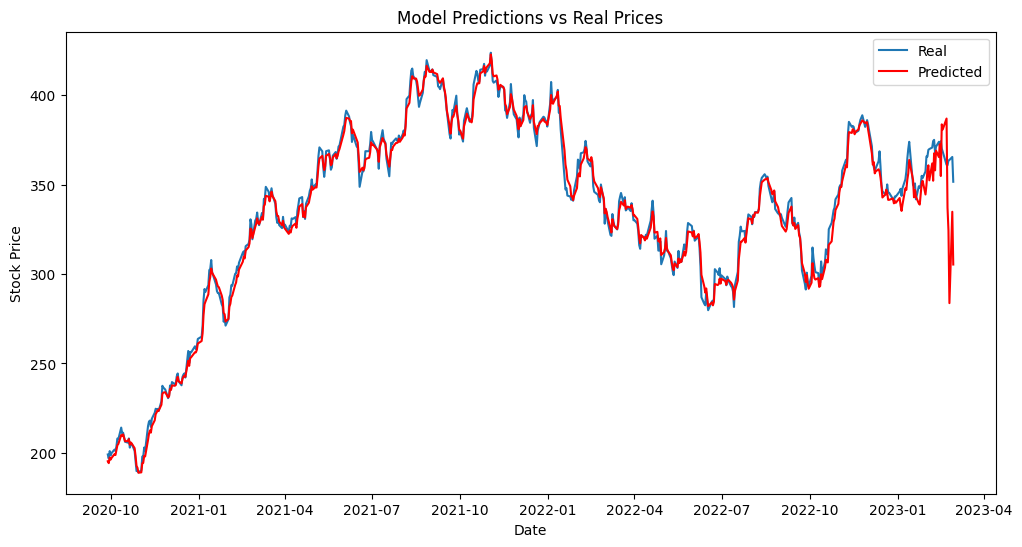

In [26]:
# Plot final Predictions
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test_scaled_df.index, y_test, label='Real')
plt.plot(test_scaled_df.index, y_pred, color='red', label='Predicted')
plt.title('Model Predictions vs Real Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Livro Professor Rogério

In [42]:
import yfinance

In [40]:
import seaborn as sns

In [ ]:
# prompt: faça download dos dados de 2024 até hoje vindo da yfinance em relação aao ativo LMND

import yfinance as yf

# Download data from 2024 to today for LMND
lmnd_data = yf.download("LMND", start="2024-01-01")

# Print the downloaded data
print(lmnd_data)


In [43]:
# prompt: faça download dos dados de 2024 até hoje vindo da yfinance em relação aao ativo LMND

import yfinance as yf

# Download data from 2024 to today for LMND
lmnd_data = yf.download("LMND", start="2024-01-01")

# Print the downloaded data
print(lmnd_data)

[*********************100%***********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2024-01-02  16.000000  17.462000  15.900000  17.040001  17.040001  2932400
2024-01-03  16.500000  16.629999  16.160000  16.219999  16.219999  1347500
2024-01-04  16.290001  16.920000  16.010000  16.610001  16.610001  1596000
2024-01-05  16.459999  17.030001  16.230000  16.549999  16.549999  1248300
2024-01-08  16.780001  18.270000  16.450001  18.250000  18.250000  2464200
...               ...        ...        ...        ...        ...      ...
2024-10-08  15.720000  15.980000  15.670000  15.730000  15.730000   917300
2024-10-09  15.530000  16.389999  15.270000  16.350000  16.350000  1302200
2024-10-10  16.190001  17.145000  16.080000  16.920000  16.920000  1695100
2024-10-11  16.920000  17.459999  16.870001  17.389999  17.389999  1491300
2024-10-14  17.490000  17.645000  17.160299  17.540001  17.540001  1026450

[198 rows x 6 columns]


In [45]:
df = lmnd_data['Adj Close']
df

,Adj Close
Date,
2024-01-02,17.040001
2024-01-03,16.219999
2024-01-04,16.610001
2024-01-05,16.549999
2024-01-08,18.250000
...,...
2024-10-08,15.730000
2024-10-09,16.350000
2024-10-10,16.920000


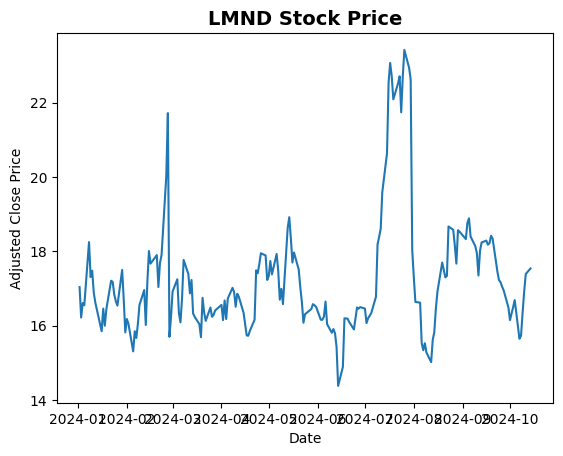

In [52]:
# prompt: aplique esse código ao LMND: sns.lineplot(x = df.index, y = df['Adj Close'])
# plt.title('Bike Sharing Demanding', fontsize=14, weight='bold')
# plt.xlabel('Days')
# plt.ylabel('Bike Demands')
# plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is defined as in your code (lmnd_data['Adj Close'])

sns.lineplot(x=df.index, y=df)
plt.title('LMND Stock Price', fontsize=14, weight='bold')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.show()


### Modelo de Aprendizado de Máquina

Para o Aprendizado de Máquina vamos empregar duas funções, uma para criar o conjunto de entradas com os termos regressores da Séries (empregaremos 7 termos, no valendo da análise do modelo ARIMA anterior) e outra para separar o conjunto de Treinamento e Teste da Série. Empregaremos 20% dos dados mais recentes para o Teste de Previsão dos valores.

In [ ]:
def ml_timeseries_df(df, n_lags, prefix=''):

	df_ml = pd.DataFrame()

	for i in range(n_lags,0,-1):
		df_ml[prefix + 't-' + str(i)] = df.shift(i).values[:,0]
	df_ml['t'] = df.values[:,0]
	df_ml = df_ml[n_lags:]
	df_ml = df_ml.reset_index(drop=True)

	return df_ml

df = ml_timeseries_df(bikes[['cnt']], n_lags=7)
df.head()

In [54]:
# prompt: crie  lags para o LMD seguindo o padrão desse código: def ml_timeseries_df(df, n_lags, prefix=''):
# 	df_ml = pd.DataFrame()
# 	for i in range(n_lags,0,-1):
# 		df_ml[prefix + 't-' + str(i)] = df.shift(i).values[:,0]
# 	df_ml['t'] = df.values[:,0]
# 	df_ml = df_ml[n_lags:]
# 	df_ml = df_ml.reset_index(drop=True)
# 	return df_ml
# df = ml_timeseries_df(bikes[['cnt']], n_lags=7)
# df.head()

def ml_timeseries_df(df, n_lags, prefix=''):
  df_ml = pd.DataFrame()
  for i in range(n_lags, 0, -1):
    df_ml[prefix + 't-' + str(i)] = df.shift(i).values[:, 0]
  df_ml['t'] = df.values[:, 0]
  df_ml = df_ml[n_lags:]
  df_ml = df_ml.reset_index(drop=True)
  return df_ml

lmnd_df = lmnd_data[['Adj Close']]
lmnd_df_lagged = ml_timeseries_df(lmnd_df, n_lags=7)
lmnd_df_lagged.head()

         t-7        t-6        t-5        t-4        t-3        t-2  \
0  17.040001  16.219999  16.610001  16.549999  18.250000  17.309999   
1  16.219999  16.610001  16.549999  18.250000  17.309999  17.480000   
2  16.610001  16.549999  18.250000  17.309999  17.480000  16.889999   
3  16.549999  18.250000  17.309999  17.480000  16.889999  16.620001   
4  18.250000  17.309999  17.480000  16.889999  16.620001  15.850000   

         t-1          t  
0  17.480000  16.889999  
1  16.889999  16.620001  
2  16.620001  15.850000  
3  15.850000  16.459999  
4  16.459999  16.000000  


Organizado os dados desse modo podemos separar a primeira porção dos dados, $0.8$, para o treinamento do modelo e aplicarmos ao restante, $0.2$, o *forecasting* observando os resultados.

In [57]:
def split_train_test(X, y, test_perc=0.2):

  test_size = int(len(df) * test_perc)
  train_size = len(df) - test_size

  X_train, y_train  = X[:train_size], y[:train_size]
  X_test, y_test = X[train_size:], y[train_size:]

  return X_train, y_train, X_test, y_test

X = df.drop(columns='t')
y = df[['t']]

X_train, y_train, X_test, y_test = split_train_test(X, y, test_perc=0.2)

KeyError: "None of [Index(['t'], dtype='object', name='Date')] are in the [index]"

In [58]:
def split_train_test(X, y, test_perc=0.2):

  test_size = int(len(lmnd_df_lagged) * test_perc)
  train_size = len(lmnd_df_lagged) - test_size

  X_train, y_train  = X[:train_size], y[:train_size]
  X_test, y_test = X[train_size:], y[train_size:]

  return X_train, y_train, X_test, y_test

X = lmnd_df_lagged.drop(columns='t')
y = lmnd_df_lagged[['t']]

X_train, y_train, X_test, y_test = split_train_test(X, y, test_perc=0.2)

---

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable

### Preparação dos Dados

Os dados serão organizados do mesmo modo que empregamos antes, embora existam, no caso das redes LSTM outras formas mais eficientes de empregarmos.

In [ ]:
df = ml_timeseries_df(bikes[['cnt']], n_lags=7)
df.head(7)

,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
0,1039.0,3161.0,3534.0,3618.0,2351.0,3505.0,1436.0,1813
1,3161.0,3534.0,3618.0,2351.0,3505.0,1436.0,1813.0,3418
2,3534.0,3618.0,2351.0,3505.0,1436.0,1813.0,3418.0,3960
3,3618.0,2351.0,3505.0,1436.0,1813.0,3418.0,3960.0,3904
4,2351.0,3505.0,1436.0,1813.0,3418.0,3960.0,3904.0,3673
5,3505.0,1436.0,1813.0,3418.0,3960.0,3904.0,3673.0,3546
6,1436.0,1813.0,3418.0,3960.0,3904.0,3673.0,3546.0,1531


Modelos de Deep Learning empregam os dados no formato de **Tensores** que são arrays multidimensionais bastante semelhantes aos empregados no `NumPy` mas que possuem algoritmos mais eficientes para o processamento além de acesso a recursos de GPU. Nesses modelos dos dados de entrada e saída são em geral normalizados.

In [ ]:
min = df.min().min()
max = df.max().max()

In [ ]:
for c in df:
  df[c] = ( df[c] - min ) / ( max - min )

In [ ]:
min = df_.min().min()
max = df.max().max()

In [ ]:
for c in df:
  df[c] = ( df[c] - min ) / ( max - min )

Dados normalizados:

In [ ]:
df.head(7)

,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
0,0.052639,0.347361,0.399167,0.410833,0.234861,0.395139,0.107778,0.160139
1,0.347361,0.399167,0.410833,0.234861,0.395139,0.107778,0.160139,0.383056
2,0.399167,0.410833,0.234861,0.395139,0.107778,0.160139,0.383056,0.458333
3,0.410833,0.234861,0.395139,0.107778,0.160139,0.383056,0.458333,0.450556
4,0.234861,0.395139,0.107778,0.160139,0.383056,0.458333,0.450556,0.418472
5,0.395139,0.107778,0.160139,0.383056,0.458333,0.450556,0.418472,0.400833
6,0.107778,0.160139,0.383056,0.458333,0.450556,0.418472,0.400833,0.120972


Armazenados como Tensores e separados nos conjuntos de Treinamento e Teste como antes. Note a dimensão dos Tensores.

In [ ]:
X = df.drop(columns='t')
y = df[['t']]

X = torch.tensor(np.array(X)).unsqueeze(-1)
y = torch.tensor(np.array(y))

X = X.type(torch.float)
y = y.type(torch.float)

X_train, y_train, X_test, y_test = split_train_test(X, y, test_perc=0.2)

In [ ]:
X.shape

torch.Size([355, 7, 1])

In [ ]:
y.shape

torch.Size([355, 1])

### Modelo da Rede e Treinamento

As duas funções a seguir são modelos bastante típicos de definição de uma rede e do seu treinamento e você, se tiver interesse, pode encontrar inúmeras referências e tutoriais dessas funções no site do projeto https://pytorch.org/.

#### Classe de Definição da Rede LSTM

In [ ]:
def split_train_test(X, y, test_perc=0.2):

  test_size = int(len(lmnd_df_lagged) * test_perc)
  train_size = len(lmnd_df_lagged) - test_size

  X_train, y_train  = X[:train_size], y[:train_size]
  X_test, y_test = X[train_size:], y[train_size:]

  return X_train, y_train, X_test, y_test

X = lmnd_df_lagged.drop(columns='t')
y = lmnd_df_lagged[['t']]

X_train, y_train, X_test, y_test = split_train_test(X, y, test_perc=0.2)

In [76]:
import torch

def split_train_test(X, y, test_perc=0.2):
  test_size = int(len(lmnd_df_lagged) * test_perc)
  train_size = len(lmnd_df_lagged) - test_size

  X_train, y_train  = X[:train_size], y[:train_size]
  X_test, y_test = X[train_size:], y[train_size:]

  # Convert to PyTorch tensors
  X_train = torch.tensor(X_train.values, dtype=torch.float32)
  y_train = torch.tensor(y_train.values, dtype=torch.float32)
  X_test = torch.tensor(X_test.values, dtype=torch.float32)
  y_test = torch.tensor(y_test.values, dtype=torch.float32)

  return X_train, y_train, X_test, y_test

# Assuming 'lmnd_df_lagged' is your DataFrame
X = lmnd_df_lagged.drop(columns='t')
y = lmnd_df_lagged[['t']] # Assuming 't' is your target column

# Now call the function to get the tensors
X_train, y_train, X_test, y_test = split_train_test(X, y)

----

In [69]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [74]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, (h_out, cn) = self.lstm(x)

        h_out = h_out[-1]                         # saída da última camada para a camada fc
        h_out = h_out.view(-1,self.hidden_size)
        out_final = self.fc(h_out)

        return out_final

#### Classe de Treinamento da Rede

De modo análogo a um modelo neural em camadas o aprendizado, ou o ajuste dos pesos da rede, se dá de forma iterativa e emprega um otimizador que busca a cada etapa do treinamento encontrar valores para os pesos que minimizem o erro de saída do modelo.

In [67]:
def train(model, optmizer, loss_f, num_epochs, data_train_x, data_train_y):

  for epoch in range(num_epochs):

    outputs = model(data_train_x)
    loss = loss_f(outputs, data_train_y)

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
    if epoch % 500 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

In [70]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1 # input size!!! uma única série de dados
hidden_size = 8

for num_layers in range(2,3):

  model = LSTM(input_size, hidden_size, num_layers)

  loss_function = torch.nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train(model, optimizer, loss_function, num_epochs, X_train, y_train)

  model.eval()


AttributeError: 'DataFrame' object has no attribute 'dim'

In [73]:
import torch
import torch.nn as nn

# ... (rest of your imports)


def train(model, optimizer, loss_f, num_epochs, data_train_x, data_train_y):
    # Convert data_train_x and data_train_y to PyTorch tensors before training
    data_train_x = torch.tensor(data_train_x.values, dtype=torch.float32)
    data_train_y = torch.tensor(data_train_y.values, dtype=torch.float32)

    for epoch in range(num_epochs):
        outputs = model(data_train_x)
        loss = loss_f(outputs, data_train_y)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        if epoch % 500 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

In [77]:
prediction = model(X)
data_predict = prediction.data.numpy()


AttributeError: 'DataFrame' object has no attribute 'dim'

In [87]:
import torch

# ... (rest of your code)

# Convert X to a PyTorch tensor before prediction
X = torch.tensor(X.values, dtype=torch.float32)

prediction = model(X)
data_predict = prediction.data.numpy()

TypeError: must be real number, not builtin_function_or_method

In [86]:
import torch

# ... (rest of your code)

# Assuming X has 7 features and you want to use only the first feature
X_selected = X[[X.columns[0]]]  # Select the first column of X

# Convert X_selected to a PyTorch tensor before prediction
X_tensor = torch.tensor(X_selected.values, dtype=torch.float32)

prediction = model(X_tensor)
data_predict = prediction.data.numpy()

AttributeError: 'Tensor' object has no attribute 'columns'

In [80]:
# ... (in your model definition)
input_size = 7  # Change input size to 7 to match your data
hidden_size = 8
# ... (rest of your model definition)

In [82]:
#@markdown
def plot_forecast(y, y_pred, X_train, title='Forecasting'):

  plt.plot(y, alpha=0.3, label='Real', color='k')
  plt.plot(y_pred, alpha=0.7, label='Forecast', color='k', linestyle='--')

  plt.plot(y_pred[0:X_train.shape[0]], alpha=0.9, label='Predicted', color='k', linestyle=':')

  plt.vlines(x=y.index[X_train.shape[0]] , ymin=0, ymax=y.max(), linestyle='--')

  plt.title(title)
  plt.xlabel('Days')
  plt.ylabel('Bike Demands')

  plt.text(100, 0 , '0.8, conjunto de treinamento')
  plt.text(300 , 0 , '0.2, de teste')
  plt.legend()
  plt.show()

  return

In [85]:
plot_forecast(lmnd_df_lagged[['t']] , data_predict, X_train, title='Bike Sharing Demanding - LSTM Deep Learning Regressor')

NameError: name 'data_predict' is not defined

Para obtermos as métricas nas mesmas medidas dos modelos anteriores vamos reescalar novamente os dados voltando aos valores originais antes da normalização.

In [84]:
plot_forecast(df['t'], data_predict, X_train, title='Bike Sharing Demanding - LSTM Deep Learning Regressor')

KeyError: 't'

In [ ]:
y_forecast = data_predict[train_size::].reshape(-1) * (max - min) + min
y_real = np.array( y[train_size::] ).reshape(-1) * (max - min) + min

cur_metrics = forecast_accuracy(y_forecast, y_real)

dict_metrics['LSTM Deep Learning Regressor'] = cur_metrics

MSE: 	 1748582.62
MAPE: 	 0.55
ME: 	 487.16
MAE: 	 887.19
MPE: 	 0.46
RMSE: 	 1322.34
ACF1: 	 0.29
CORR: 	 0.43
